In [55]:
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,classification_report
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers



In [ ]:
Trainfile=input("Enter the Train file path with double back-slash")
folder=input("Enter the path for train_images folder: ")
testfile=input("Enter the Test file path with double back-slash")
test_image_folder=input("Enter the path for test_images folder: ")

In [ ]:
train_csv=pd.read_csv(Trainfile)

In [ ]:
print(train_csv.head(5))

In [ ]:
image_paths=[]
labels=[]
for index, row in train_csv.iterrows():
    image_path = os.path.join(folder,row['filename']) 
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(row['label'])
    else:
        print(f"Image not found: {image_path}")


In [ ]:
np_image_data = []
np_labels = []
for image_path, label in zip(image_paths, labels):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize pixel values    
    np_image_data.append(img_array)
    np_labels.append(label)

# Convert lists to numpy arrays
np_image_data = np.array(np_image_data)
np_labels = np.array(np_labels)


In [ ]:
def calculate_class_proportions(labels):#Function Definition
    class_counts = {}
    total_samples = len(labels)

    # Count the number of samples for each class
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Calculate the proportion of samples for each class
    class_proportions = {}
    for class_label, count in class_counts.items():
        class_proportions[class_label] = count / total_samples
    if(class_proportions[0]< 0.5):
        Minority_class=0
        Majority_class=1
        balanced_state=0
    elif (class_proportions[1]< 0.5):
        Minority_class=1
        Majority_class=0
        balanced_state=0
    else:
        balanced_state=1
    return class_proportions,Minority_class,Majority_class,balanced_state

class_proportions,Minority_class,Majority_class,balanced_state = calculate_class_proportions(np_labels)#Fucntion Invocation
print("Class proportions:", class_proportions)
print("Majority_class:",Majority_class )
print("Minority_class:",Minority_class )
#print("Balance_State:",balanced_state )



In [ ]:
original_label_counts = np.bincount(np_labels)
if Minority_class==1:
    minority_label = 1
    majority_label = 0
else:
    minority_label = 0
    majority_label = 1
labels = [f'Label {minority_label}', f'Label {majority_label}']
counts = [original_label_counts[minority_label], original_label_counts[majority_label]]
plt.bar(labels, counts, color=['blue','orange'])
plt.xlabel('Label')
plt.ylabel('Count')
if balanced_state==0:
    plt.title('Imbalanced Data')
else:
    plt.title("Balanced Data")
plt.show()


In [ ]:
if balanced_state==0:
    total_samples = len(np_labels)
    minority_indices = np.where(np_labels == Minority_class)[0]#finding index for class minor
    majority_indices = np.where(np_labels != Minority_class)[0]#finding index for class major
    minority_data = np_image_data[minority_indices]
    majority_data = np_image_data[majority_indices]
    minority_labels=np_labels[np_labels == Minority_class]
    majority_labels=np_labels[np_labels != Minority_class]
    num_minority_samples=len(minority_data)
    num_augmented_minority_samples = int(0.5*(total_samples)) - num_minority_samples
    datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
    augmented_minority_data=[]
    augmented_minority_labels=[]
    for i, (x_batch, y_batch) in enumerate(datagen.flow(minority_data, minority_labels, batch_size=32)):
        augmented_minority_data.extend(x_batch)
        augmented_minority_labels.extend(y_batch)
        #print(len(augmented_minority_labels),i)
        if i+1 >=num_augmented_minority_samples//32:
            break
    np_augmented_minority_data=np.array(augmented_minority_data)
    np_augmented_minority_labels=np.array(augmented_minority_labels)
    np_con_agu_minority_data=np.concatenate([np_augmented_minority_data,minority_data])
    np_con_agu_minority_label=np.concatenate([np_augmented_minority_labels,minority_labels])
    balanced_data=np.concatenate([np_con_agu_minority_data,majority_data])
    balanced_label=np.concatenate([np_con_agu_minority_label,majority_labels])
else:
    balanced_data=np_image_data
    balanced_label=np_labels




In [ ]:
if balanced_state==0:
    original_label_counts = np.bincount(np_labels)
    augmented_label_counts = np.bincount(balanced_label)
    if Minority_class==1:
        minority_label = 1
        majority_label = 0
    else:
        minority_label = 0
        majority_label = 1
    labels = [f'Label {minority_label} (Before)', f'Label {majority_label} (Before)',
              f'Label {minority_label} (After)', f'Label {majority_label} (After)']

    counts = [original_label_counts[minority_label], original_label_counts[majority_label],
          augmented_label_counts[minority_label], augmented_label_counts[majority_label]]

    plt.bar(labels, counts, color=['blue', 'orange', 'blue', 'orange'])
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Comparison of Minority and Majority Labels Before and After oversampling')
    plt.show()


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(balanced_data, balanced_label, test_size=0.33, random_state=42)


In [124]:
batch_s=32
epoch=10
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_X = X[offset:offset+batch_size]
            batch_y = y[offset:offset+batch_size]
            yield batch_X, batch_y

train_generator = data_generator(X_train, y_train, batch_size=batch_s)
steps_per_epoch = len(X_train) // batch_s #batch size


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=epoch, 
                              validation_data=(X_val, y_val))


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 64)       

In [86]:
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 246016)            0         
                                                                 
 dense_8 (Dense)             (None, 64)               

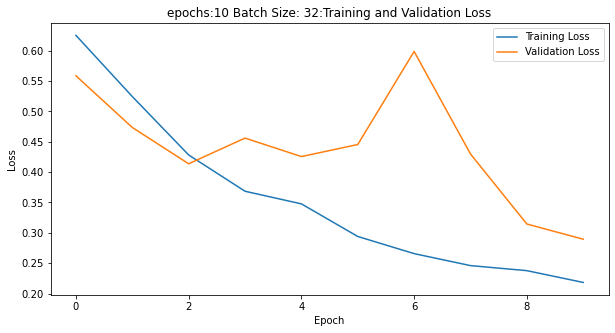

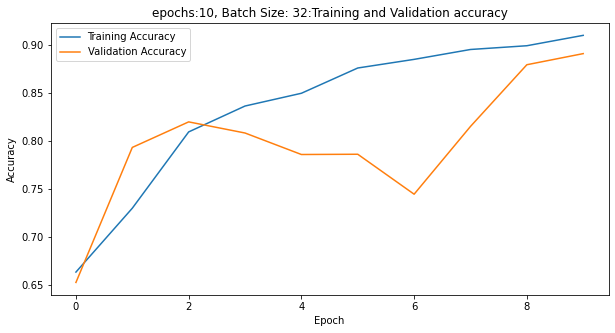

In [125]:
# Extracting train accuracy and loss
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Extracting validation accuracy and loss
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"epochs:{epoch} Batch Size: {batch_s}:Training and Validation Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"epochs:{epoch}, Batch Size: {batch_s}:Training and Validation accuracy")
plt.legend()
plt.show()



In [126]:
y_pred_proba = model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int)  # Assuming binary classification, adjust threshold if needed
    
    # Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average=None)
    
    # Calculate macro F1 score
macro_f1 = np.mean(f1)
print(classification_report(y_val, y_pred))  
print(macro_f1)

119/119 [==============================] - 30s 243ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2483
           1       0.89      0.79      0.83      1321

    accuracy                           0.89      3804
   macro avg       0.89      0.87      0.88      3804
weighted avg       0.89      0.89      0.89      3804

0.8758761422007814


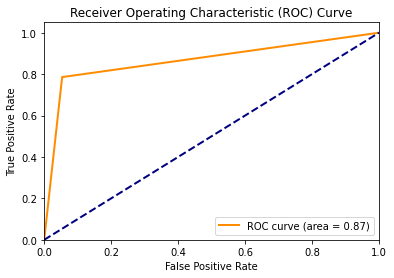

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted probabilities for the positive class
# Example:
# y_true = [0, 1, 1, 0, 1]
# y_pred = [0.2, 0.7, 0.6, 0.3, 0.8]

# Compute ROC curve and ROC area for positive class
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [106]:
fpr

array([0.        , 0.12887636, 1.        ])

In [107]:
tpr

array([0.        , 0.84859955, 1.        ])

In [108]:
roc_auc

0.859861593277893

In [89]:
import matplotlib.pyplot as plt
import cv2  # OpenCV library for image processing


1/1 [==============================] - 0s 31ms/step


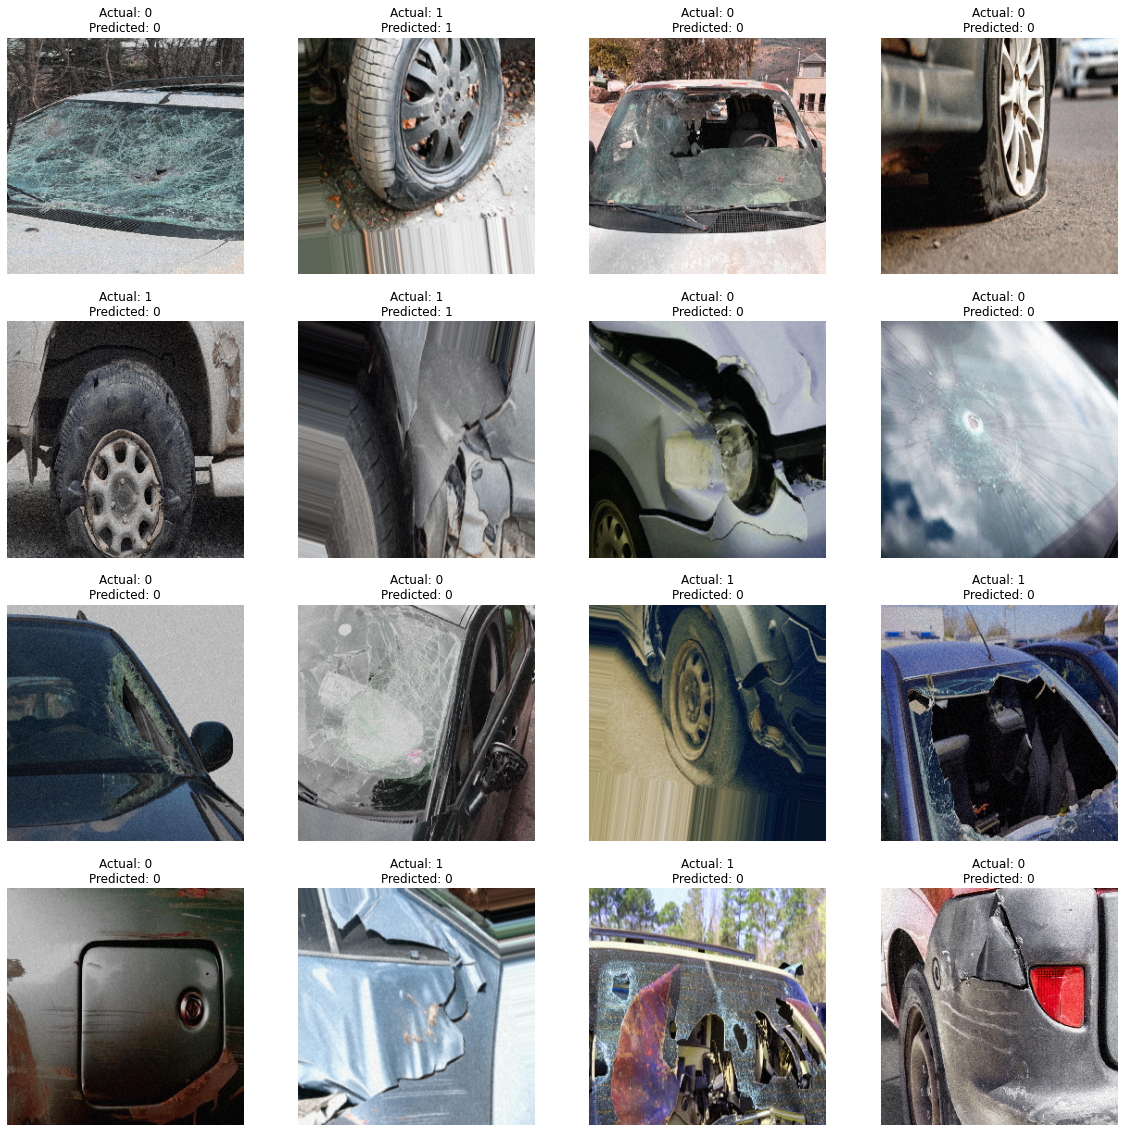

1/1 [==============================] - 0s 31ms/step


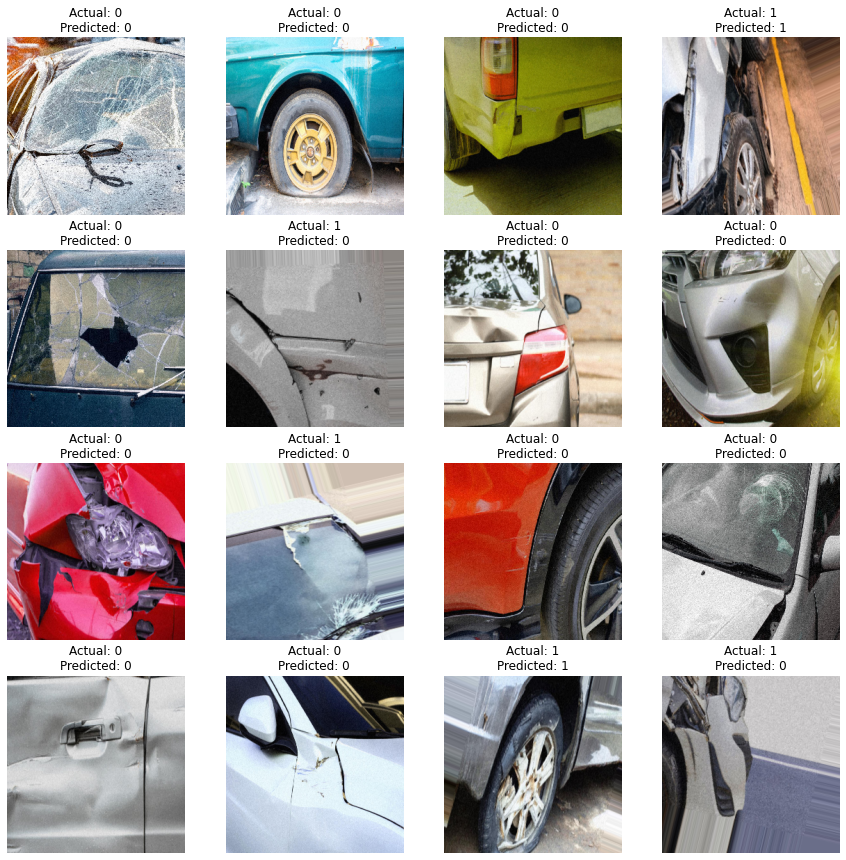

1/1 [==============================] - 0s 22ms/step


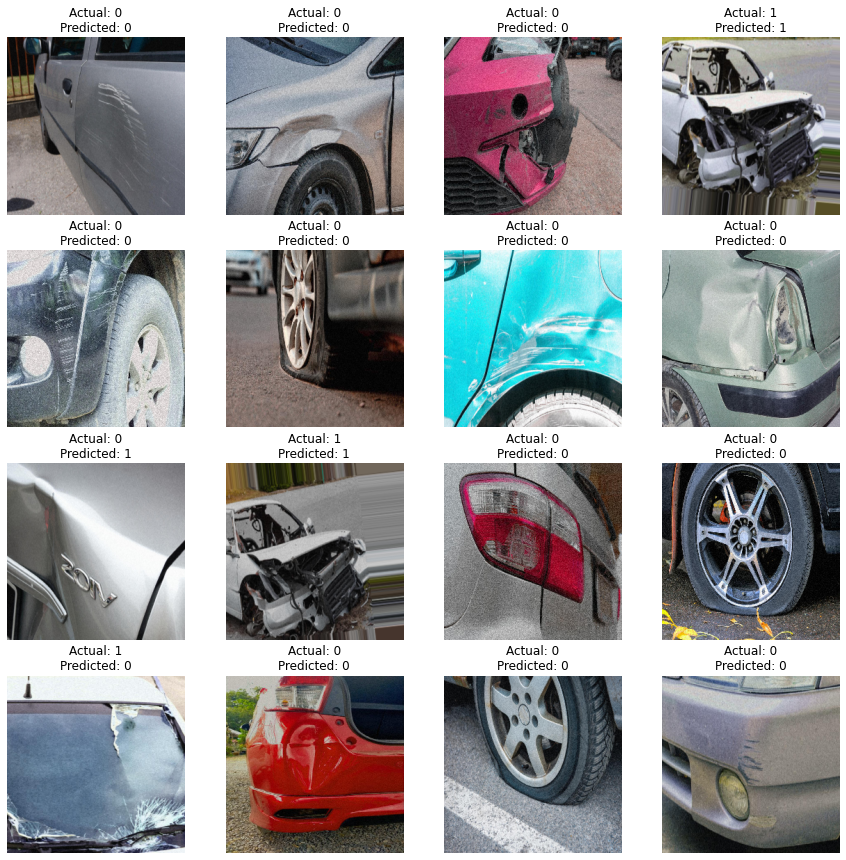

1/1 [==============================] - 0s 22ms/step


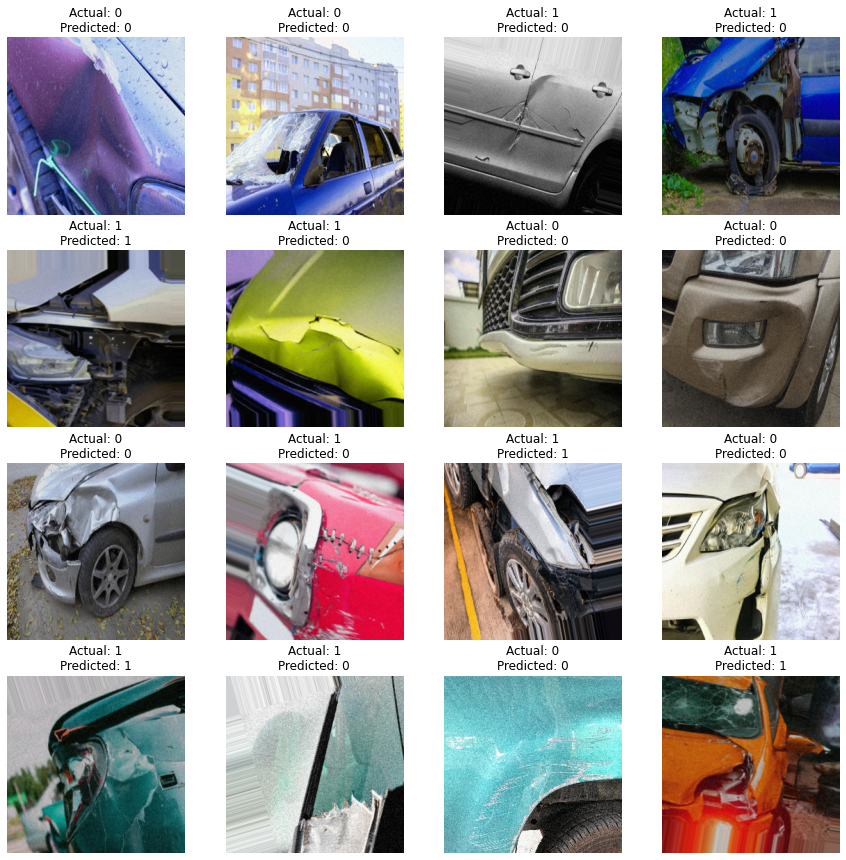

1/1 [==============================] - 0s 31ms/step


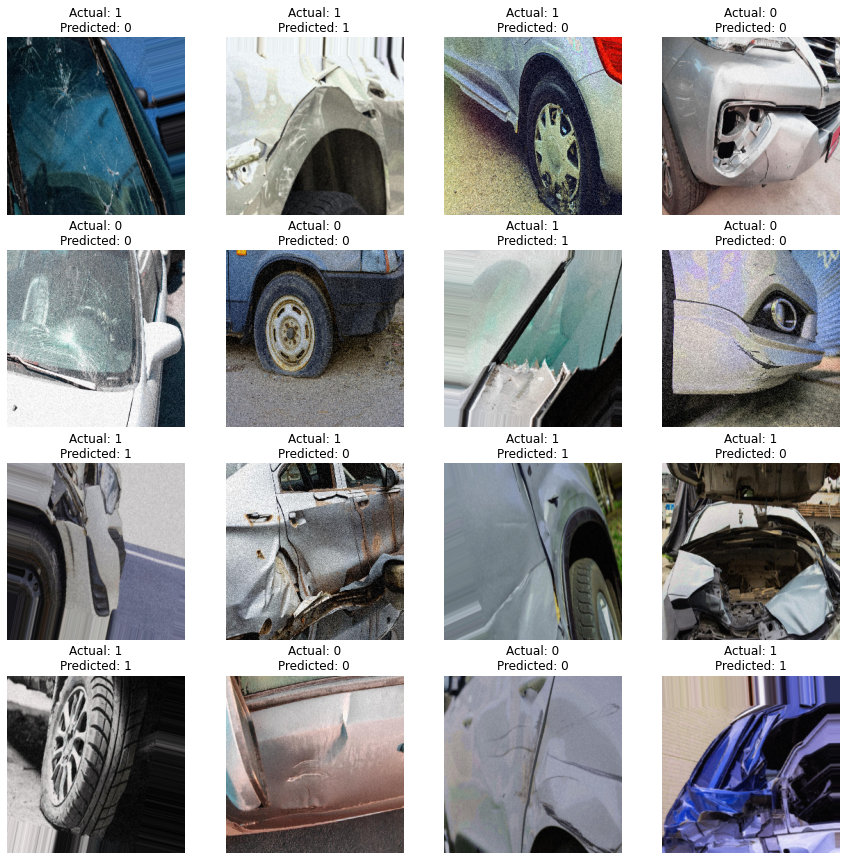

1/1 [==============================] - 0s 38ms/step


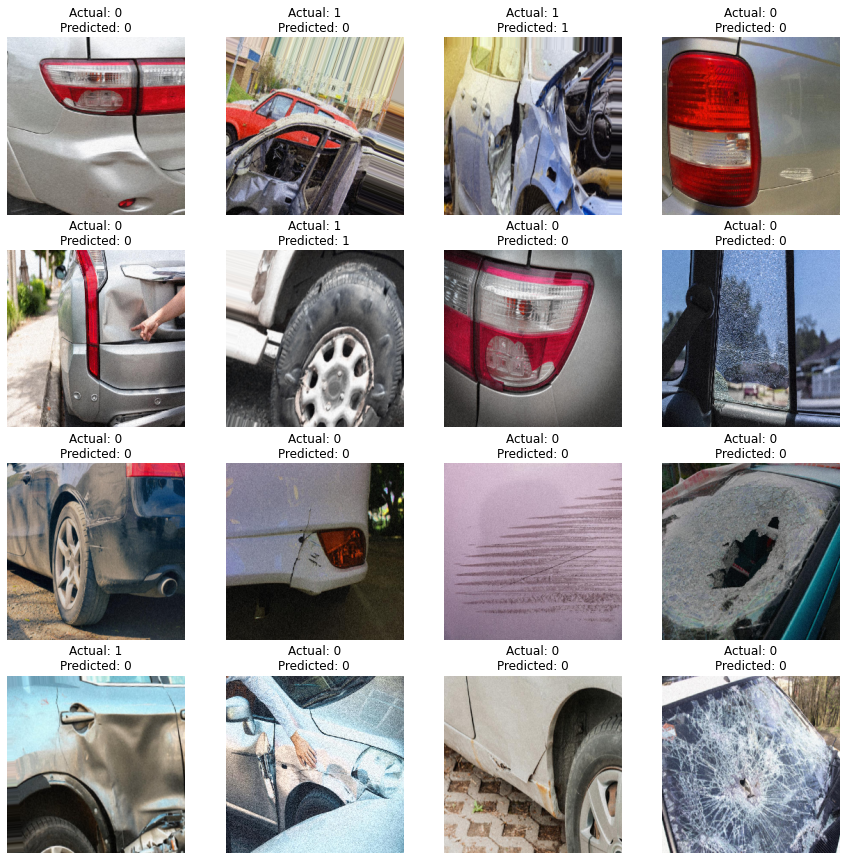

1/1 [==============================] - 0s 31ms/step


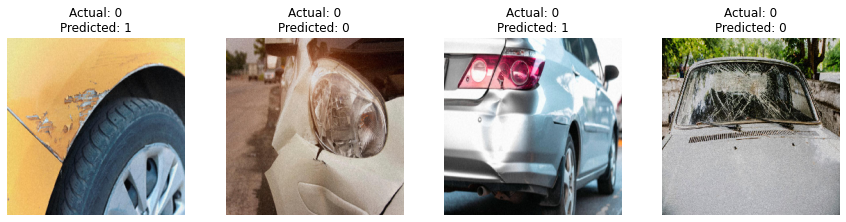

In [90]:

plt.figure(figsize=(20,20))

for index, (image, label) in enumerate(zip(X_val[:100], y_val[:100])):
    image = (image * 255).astype('uint8')
    resized_image = cv2.resize(image, (256, 256))
    ax = plt.subplot(4, 4, index % 16 + 1)
    ax.imshow(image)
    y_pred_proba = model.predict(resized_image.reshape(1, 256, 256, 3))
    y_pred = (y_pred_proba > 0.5).astype(int).squeeze()
    ax.set_title(f"Actual: {label}\nPredicted: {y_pred}")
    ax.axis('off')
    if (index + 1) % 16 == 0:
        plt.show()
        plt.figure(figsize=(15, 15))
    
    

In [91]:
np.max(y_pred_proba)
print(y_pred_proba[0])

[0.]


In [92]:
y_pred_proba

array([[0.]], dtype=float32)

In [93]:
test_csv=pd.read_csv(testfile)

In [94]:
image_paths_test=[]
test_image_id=[]

for index, row in test_csv.iterrows():
    # Construct the full path to the image
    image_path = os.path.join(test_image_folder,row['filename']) 
    
    image_id=row['image_id']

    if os.path.exists(image_path):
        image_paths_test.append(image_path)
        test_image_id.append(image_id)
    else:
        print(f"Image not found: {image_path}")


In [128]:
def image_generator(image_paths_test, batch_size=32):
    num_images = len(image_paths_test)
    for i in range(0, num_images, batch_size):
        batch_paths = image_paths_test[i:i+batch_size]
        batch_images = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img) / 255.0
            batch_images.append(img_array)
        yield np.array(batch_images)

# Assuming 'model' is defined and 'image_paths_test' is populated correctly

y_prediction_list = []

for np_test_data_batch in image_generator(image_paths_test, batch_size=32):
    y_pred_batch = model.predict(np_test_data_batch)
    y_prediction_batch = (y_pred_batch > 0.5).astype(int).squeeze()
    y_prediction_list.extend(y_prediction_batch)

# y_prediction_list will contain predictions for all images


1/1 [==============================] - 0s 143ms/step


In [132]:
result=pd.DataFrame(columns=['image_id','label'])
result['image_id']=test_image_id
result['label']=y_prediction_list

In [133]:
print(result[result['label']==0].count())
print(result[result['label']==1].count())

image_id    3184
label       3184
dtype: int64
image_id    278
label       278
dtype: int64


In [123]:
result.to_csv('C:\\Users\\Admin\\Desktop\\Car-Insurance\\sample.csv', index=False)  # Setting index=False prevents pandas from writing row indices


In [129]:
score=model.evaluate()

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>